In [41]:
%load_ext autoreload
%autoreload 2

In [47]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

Let $X \sim N(\theta, 1)$ be the data of interest.
We restrict to $\theta \in [a,b]$ for some fixed $a, b$.
We wish to estimate $G(\theta) := \theta$ by using our estimator $F(X) := \max(a, \min(X, b))$.
This notebook covers our bias estimation method.
That is, we wish to estimate $E_\theta[F(X)] - G(\theta)$ on a grid of $\theta$'s.

Let $f(\theta) := E_\theta[F(X) - G(\theta)]$.
Let $$\tilde{F}(X) := \frac{F(X) - a}{b-a}$$ 
so that $$f(\theta) = (b-a) E_\theta[\tilde{F}(X)] + a - G(\theta)$$
Given $\theta_0$, we obtain the Tilt-Bound on $E_\theta[\tilde{F}(X)]$,
which gives us the bound
$$(b-a) U(\theta_0, v, q, E_{\theta_0}[\tilde{F}(X)]) + a - G(\theta)$$

In [57]:
def esti(x, a, b):
    return jnp.maximum(a, jnp.minimum(x, b))


def esti_tilde(x, a, b):
    return (esti(x, a, b) - a) / (b - a)


def G(x):
    return x

In [49]:
def exp_esti_tilde(theta, sig, a, b):
    cdf_a = jax.scipy.stats.norm.cdf(a, theta, sig)
    cdf_b = jax.scipy.stats.norm.cdf(b, theta, sig)
    out = a * cdf_a
    out = out + theta * (cdf_b - cdf_a)
    out = out + sig**2 * (
        jax.scipy.stats.norm.pdf(a, theta, sig)
        - jax.scipy.stats.norm.pdf(b, theta, sig)
    )
    out = out + b * (1 - cdf_b)
    return (out - a) / (b - a)

In [100]:
def tilt_bound_fwd(v, f0):
    logf0 = jnp.log(f0)
    q_opt = jnp.maximum(jnp.sqrt(-2 * logf0) / jnp.abs(v), 1)
    expo = 0.5 * (q_opt - 1) * v**2 - logf0 / q_opt
    return f0 * jnp.exp(expo)

In [105]:
a = 1
b = 4
radius = jnp.minimum(1e-2, (b - a) / 2)
theta_0 = (a + b) / 2
vs = jnp.linspace(-radius, radius, 100)
f0 = exp_esti_tilde(theta_0, 1, a, b)

In [106]:
tilt_bound_fwd_jv = jax.jit(jax.vmap(tilt_bound_fwd, in_axes=(0, None)))

In [107]:
bounds = tilt_bound_fwd_jv(vs, f0)
bounds = a + (b - a) * bounds - G(theta_0 + vs)
true_bias = a + (b - a) * exp_esti_tilde(theta_0 + vs, 1, a, b) - G(theta_0 + vs)

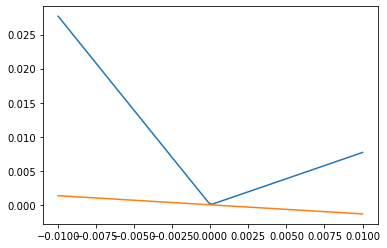

In [108]:
plt.plot(vs, bounds)
plt.plot(vs, true_bias)